# p.17 Investigating Bias

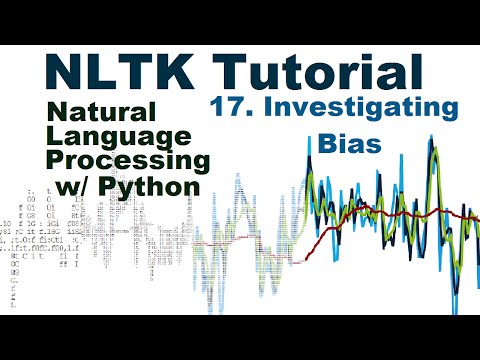

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('h44hI7lr8w4')

## 1. Investigate bias

Bias against positive or negative

## 2. Example

In [3]:
import nltk
import random
import string
from nltk.corpus import movie_reviews, stopwords
from nltk.classify.scikitlearn import SklearnClassifier
import pickle

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from nltk.classify import ClassifierI
from statistics import mode

class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
            
        return mode(votes)
    
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
            
        choice_votes = votes.count(mode(votes))
        conf = choice_votes/len(votes)
        
        return conf

# Oneliner which is equivalent to 
# documents = []
# for category in movie_reviews.categories():
#     for fileid in movie_reviews.fileids(category):
#         documents.append(list(movie_reviews(fileid)), category)

# Load 2000 movie reviews where 1000 are positive and the other 1000 are negative.
# The first 1000 reviews are negative and the remaining 1000 reviews are positive.
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

## BUGBUG: if we comment out the following shuffle line, it will create bias in the test set 
## which will contain only negative or positive movie reviews.
random.shuffle(documents)

# Add all the words to a single list.
all_words = []
for w in movie_reviews.words():
    all_words.append(w.lower())
    
# Remove the stop words and the punctuations.
stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(set(string.punctuation))
#print("stop_words:\n", stop_words)

filtered_words = [w for w in all_words if w not in stop_words]

# Note that the words in "filtered_words_dist" are NOT sorted in their frequecies.
filtered_words_dist = nltk.FreqDist(filtered_words)

# Restrict our 'features' to the most common 3000 words.
word_features = filtered_words_dist.most_common(3000)
word_features = [wf[0] for wf in word_features]

# Check if each of the most common 3000 words is present in one movie review.
# The input document is a list of words from a movie review.
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
        
    return features

# print((find_features(movie_reviews.words('neg/cv000_29416.txt'))))

# Label the 'features' in all the movie reviews.
featuresets = [(find_features(rev), category) for (rev, category) in documents]

# Partition the entire data set into training set and test set.
# Positive test data example if we don't do the random shuffle above.
# training_set = featuresets[:1900]
# testing_set = featuresets[1900:]

# Negative test data example if we don't do the random shuffle above.
training_set = featuresets[100:]
testing_set = featuresets[:100]

## 
## Trained naive Bayes classifer
##
classifier_f = open("naivebayes.pickle", "rb")
classifier = pickle.load(classifier_f)
classifier_f.close()

print("Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

##
## Scikit-Learn MultinomialNB
##
MultinomialNB_classifier = SklearnClassifier(MultinomialNB())
MultinomialNB_classifier.train(training_set)

print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MultinomialNB_classifier, testing_set))*100)

##
## Scikit-Learn GaussianNB
##
# GaussianNB_classifier = SklearnClassifier(GaussianNB())
# GaussianNB_classifier.train(training_set)

# print("GaussianNB_classifier accuracy percent:", (nltk.classify.accuracy(GaussianNB_classifier, testing_set))*100)

##
## Scikit-Learn BernoulliNB
##
BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)

print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

##
## Scikit-Learn LogisticRegression
##
LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)

print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

##
## Scikit-Learn SGDClassifier
##
SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)

print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)

##
## Scikit-Learn SVC
##
# The performance of the classic SVC is poor, so it is NOT used.
#SVC_classifier = SklearnClassifier(SVC())
#SVC_classifier.train(training_set)

#print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)

##
## Scikit-Learn LinearSVC
##
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)

print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

##
## Scikit-Learn NuSVC
##
NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)

print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)

voted_classifier = VoteClassifier(classifier, 
                                  MultinomialNB_classifier, 
                                  BernoulliNB_classifier, 
                                  LogisticRegression_classifier, 
                                  SGDClassifier_classifier, 
                                  LinearSVC_classifier, 
                                  NuSVC_classifier)
print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)

# print("Classification: ", voted_classifier.classify(testing_set[0][0]), 
#       "Confidence %: ", voted_classifier.confidence(testing_set[0][0])*100)
# print("Classification: ", voted_classifier.classify(testing_set[1][0]), 
#       "Confidence %: ", voted_classifier.confidence(testing_set[1][0])*100)
# print("Classification: ", voted_classifier.classify(testing_set[2][0]), 
#       "Confidence %: ", voted_classifier.confidence(testing_set[2][0])*100)
# print("Classification: ", voted_classifier.classify(testing_set[3][0]), 
#       "Confidence %: ", voted_classifier.confidence(testing_set[3][0])*100)
# print("Classification: ", voted_classifier.classify(testing_set[4][0]), 
#       "Confidence %: ", voted_classifier.confidence(testing_set[4][0])*100)
# print("Classification: ", voted_classifier.classify(testing_set[5][0]), 
#       "Confidence %: ", voted_classifier.confidence(testing_set[5][0])*100)


Naive Bayes Algo accuracy percent: 89.0
Most Informative Features
             outstanding = True              pos : neg    =     11.2 : 1.0
               ludicrous = True              neg : pos    =     10.8 : 1.0
                  finest = True              pos : neg    =      9.6 : 1.0
                 idiotic = True              neg : pos    =      8.8 : 1.0
                   mulan = True              pos : neg    =      7.6 : 1.0
            breathtaking = True              pos : neg    =      7.6 : 1.0
                  seagal = True              neg : pos    =      7.5 : 1.0
              schumacher = True              neg : pos    =      6.7 : 1.0
             wonderfully = True              pos : neg    =      6.5 : 1.0
                   anger = True              pos : neg    =      6.4 : 1.0
                   inept = True              neg : pos    =      6.1 : 1.0
                   damon = True              pos : neg    =      5.8 : 1.0
                lebowski = True   

/home/renwei/anaconda3/envs/nltk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 85.0
LinearSVC_classifier accuracy percent: 88.0
NuSVC_classifier accuracy percent: 89.0
voted_classifier accuracy percent: 90.0
